In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import itertools
from collections import Counter

# --- 1. 模型参数定义 ---
# 定义一个函数来获取不同情景下的参数
def get_parameters(scenario_name='baseline'):
    """
    根据情景名称返回对应的模型参数字典。
    您需要根据理论分析和现实情况调整这些参数。
    """
    params = {
        # 政府相关参数
        'C_G': 1.0,  # 政府建立和维护认证体系的净成本
        'S_G': 2.0,  # 认证体系成功运作时政府获得的额外社会效益
        'F_E': 0.5,  # 政府从成功认证的企业处收取的费用
        'F_I': 0.3,  # 政府从成功认证的投资机构处收取的费用 (若机构也需认证)

        # 科创企业相关参数
        'R_H': 3.0,  # 企业实质性创新并获长期投资后的高额净收益
        'R_L': 0.5,  # 企业实质性创新但未获长期投资的较低净收益 (可能为负)
        'R_O': 1.0,  # 企业进行策略性创新的常规净收益
        'B_E': 1.5,  # 企业因通过“政府认证”而获得的额外净收益增量
        'C_certE': 0.8, # 企业为获得认证所需支付的成本

        # 投资机构相关参数
        'P_H': 4.0,  # 投资机构对“经认证的实质创新企业”进行长期投资的高额回报
        'P_L': 1.0,  # 投资机构对“未经认证的实质创新企业”进行长期投资的净回报
        'P_O': 2.0,  # 投资机构进行短期投资或投资于策略性创新企业的常规回报
        'B_I': 1.0,  # 投资机构因投资“经认证企业”或利用认证体系进行决策获得的额外净收益增量
        'C_certI': 0.5  # 投资机构为利用认证体系所需支付的成本
    }

    # --- 定义不同情景的参数调整 ---
    # 您需要根据您的理论分析，在这里设置不同情景下的参数值
    # 例如：
    if scenario_name == 'baseline':
        # 理想情景，理论上E8(1,1,1)稳定
        # 确保 E8 稳定条件满足: SG + FE + FI - CG > 0, BE - CcertE + RH - RO > 0, PH + BI - CcertI - PO > 0
        params['S_G'] = 2.0
        params['B_E'] = 1.5
        params['R_H'] = 3.0
        params['R_O'] = 1.0
        params['P_H'] = 4.0
        params['B_I'] = 1.0
        params['C_certI'] = 0.5
        params['P_O'] = 2.0

    elif scenario_name == 'pessimistic':
        # 悲观情景，理论上E1(0,0,0)稳定
        # 确保 E1 稳定条件满足: -(SG + FE + FI - CG) > 0, -(BE - CcertE + RH - RO) > 0, -(PH + BI - CcertI - PO) > 0
        params['S_G'] = 0.1
        params['F_E'] = 0.05
        params['F_I'] = 0.03
        params['C_G'] = 1.0
        params['B_E'] = 0.1
        params['C_certE'] = 0.8
        params['R_H'] = 1.5
        params['R_O'] = 1.0
        params['P_H'] = 2.0
        params['B_I'] = 0.1
        params['C_certI'] = 0.5
        params['P_O'] = 2.0

    elif scenario_name == 'E6_stable':
        # 示例：使 E6(1,0,1) 理论上稳定的参数情景
        # E6 稳定条件: CG - FI < 0, R_O > R_L + B_E - C_certE, P_H + B_I - C_certI > P_O
        params['C_G'] = 1.0
        params['F_I'] = 1.5
        params['S_G'] = 0.1
        params['F_E'] = 0.1

        params['R_O'] = 2.0
        params['R_L'] = 0.5
        params['B_E'] = 0.1
        params['C_certE'] = 0.8
        params['R_H'] = 1.5

        params['P_H'] = 4.0
        params['B_I'] = 1.0
        params['C_certI'] = 0.5
        params['P_O'] = 2.0

    elif scenario_name == 'E3_stable':
        # 示例：使 E3(0,1,0) 理论上稳定的参数情景
        # E3 稳定条件: FE - CG > 0, R_L - R_O > 0, P_L - P_O > 0
        params['C_G'] = 1.0
        params['F_E'] = 1.5
        params['S_G'] = 0.1
        params['F_I'] = 0.1

        params['R_L'] = 2.0
        params['R_O'] = 1.0
        params['B_E'] = 0.1
        params['C_certE'] = 0.8
        params['R_H'] = 3.0

        params['P_O'] = 3.0
        params['P_L'] = 1.0
        params['P_H'] = 4.0
        params['B_I'] = 1.0
        params['C_certI'] = 0.5

    elif scenario_name == 'bistable':
        # 示例：使 E1(0,0,0) 和 E8(1,1,1) 都可能稳定的参数情景
        # 通常意味着一些关键参数接近阈值
        params['S_G'] = 1.0
        params['F_E'] = 0.3
        params['F_I'] = 0.2
        params['C_G'] = 1.0

        params['R_H'] = 2.5
        params['R_L'] = 0.5
        params['R_O'] = 1.0
        params['B_E'] = 0.8
        params['C_certE'] = 0.8

        params['P_H'] = 3.0
        params['P_L'] = 1.0
        params['P_O'] = 2.0
        params['B_I'] = 0.6
        params['C_certI'] = 0.5

    # 您可以根据需要添加更多情景，例如 E4, E5, E7 稳定情景

    # 确保参数符合基本经济学逻辑 (可选的断言)
    assert params['R_H'] >= params['R_L'], "RH should be >= RL"
    assert params['P_H'] >= params['P_L'], "PH should be >= PL"
    # 更多断言...

    return params

# --- 2. 复制动态方程 ---
def replicator_dynamics(state, t, params):
    """
    三方演化博弈的复制动态方程。
    state: 当前状态 [x, y, z]
    t: 时间
    params: 模型参数字典
    """
    x, y, z = state
    # 确保状态在 [0, 1] 范围内，避免数值误差导致越界
    # 使用 np.clip 可以将数组中的值限制在指定范围内
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    z = np.clip(z, 0, 1)

    # 提取参数，使用更短的变量名方便公式书写
    CG, SG, FE, FI = params['C_G'], params['S_G'], params['F_E'], params['F_I']
    RH, RL, RO, BE, CcertE = params['R_H'], params['R_L'], params['R_O'], params['B_E'], params['C_certE']
    PH, PL, PO, BI, CcertI = params['P_H'], params['P_L'], params['P_O'], params['B_I'], params['C_certI']

    # 计算期望收益 (参考您的公式推导)
    # 政府选择“建立认证体系” (x=1) 的期望收益
    UG1 = y * z * SG + y * FE + z * FI - CG
    # 政府选择“不建立认证体系” (x=0) 的期望收益
    UG0 = 0 # 根据您的假设，不建立体系时相关成本收益为0
    # 政府的平均期望收益
    UG_avg = x * UG1 + (1 - x) * UG0

    # 科创企业选择“实质性创新” (y=1) 的期望收益
    # 当政府建立认证体系 (x=1) 时，企业实质创新收益
    UE1_x1 = z * (RH + BE - CcertE) + (1 - z) * (RL + BE - CcertE)
    # 当政府不建立认证体系 (x=0) 时，企业实质创新收益
    UE1_x0 = z * RH + (1 - z) * RL # 此时与认证无关
    # 科创企业选择“实质性创新”的总期望收益 (考虑政府策略)
    UE1 = x * UE1_x1 + (1 - x) * UE1_x0

    # 科创企业选择“策略性创新” (y=0) 的期望收益
    # 根据您的支付矩阵，策略性创新收益总是 RO
    UE0 = RO
    # 科创企业的平均期望收益
    UE_avg = y * UE1 + (1 - y) * UE0

    # 投资机构选择“长期投资” (z=1) 的期望收益
    # 当政府建立认证体系 (x=1) 时，机构长期投资收益
    UI1_x1 = y * (PH + BI - CcertI) + (1 - y) * (PO - CcertI)
    # 当政府不建立认证体系 (x=0) 时，机构长期投资收益
    UI1_x0 = y * PL + (1 - y) * PO # 此时与认证无关
    # 投资机构选择“长期投资”的总期望收益 (考虑政府策略)
    UI1 = x * UI1_x1 + (1 - x) * UI1_x0

    # 投资机构选择“短期投资” (z=0) 的期望收益
    # 根据您的支付矩阵，短期投资收益总是 PO
    UI0 = PO
    # 投资机构的平均期望收益
    UI_avg = z * UI1 + (1 - z) * UI0

    # 复制动态方程
    dx_dt = x * (UG1 - UG_avg)
    dy_dt = y * (UE1 - UE_avg)
    dz_dt = z * (UI1 - UI_avg)

    # 边界条件处理：如果比例达到边界且演化方向指向外部，则速度设为0
    # 这有助于防止数值误差导致比例超出 [0, 1] 范围
    if x <= 1e-6 and dx_dt < 0: # 使用一个小的容差来处理浮点数比较
        dx_dt = 0
    if x >= 1.0 - 1e-6 and dx_dt > 0:
        dx_dt = 0
    if y <= 1e-6 and dy_dt < 0:
        dy_dt = 0
    if y >= 1.0 - 1e-6 and dy_dt > 0:
        dy_dt = 0
    if z <= 1e-6 and dz_dt < 0:
        dz_dt = 0
    if z >= 1.0 - 1e-6 and dz_dt > 0:
        dz_dt = 0


    return [dx_dt, dy_dt, dz_dt]

# --- 3. 仿真求解函数 ---

def solve_replicator_dynamics(initial_state, params, t_span):
    """
    求解复制动态方程。
    initial_state: 初始状态 [x0, y0, z0]
    params: 模型参数字典
    t_span: 时间跨度 (例如 np.linspace(0, 200, 201))
    """
    # 使用 odeint 求解微分方程组
    # rtol 和 atol 是相对和绝对容差，用于控制求解精度
    # 这些参数可能需要根据模型的具体特性进行调整，以获得稳定和准确的解
    solution = odeint(replicator_dynamics, initial_state, t_span, args=(params,), rtol=1e-8, atol=1e-8)
    return solution

def get_final_state(solution, tolerance=1e-4, check_last_steps=50):
    """
    判断仿真结果的最终状态（收敛到的均衡点）。
    solution: odeint 返回的解矩阵
    tolerance: 判断收敛到纯策略均衡点的容差
    check_last_steps: 检查最后多少步的平均值来判断收敛
    """
    # 检查最后几步的平均值是否稳定
    if solution.shape[0] < check_last_steps:
         check_last_steps = solution.shape[0] # 如果仿真步数不足，则检查所有步
    avg_last_steps = np.mean(solution[-check_last_steps:, :], axis=0)

    # 判断是否收敛到纯策略均衡点 (0或1)
    pure_strategy_equilibria = list(itertools.product([0, 1], repeat=3))
    for eq in pure_strategy_equilibria:
        if np.all(np.abs(avg_last_steps - eq) < tolerance):
            return tuple(eq) # 返回收敛到的纯策略均衡点

    # 如果没有收敛到纯策略均衡点，可能收敛到混合策略均衡或未收敛
    # 可以添加更复杂的判断逻辑，例如检查最后几步的速度是否接近零
    # 计算最后几步的平均速度
    # avg_velocity_last_steps = np.mean(np.abs(np.diff(solution[-check_last_steps:, :], axis=0)), axis=0)
    # if np.all(avg_velocity_last_steps < tolerance):
    #     return "Mixed/Other" # 假设收敛到混合策略或其他

    # 如果长时间未收敛到纯策略均衡点，且速度不接近零，可能存在周期解或混沌，或者需要更长的仿真时间
    return "Not Converged" # 默认标记为未收敛

# --- 绘图前准备完成 ---
print("绘图前准备代码已完成：模型参数定义、复制动态方程、仿真求解函数、最终状态判断函数。")
print("接下来我们将进行仿真并绘制结果图。")

# 定义纯策略均衡点名称映射，方便后续显示
eq_names = {
    (0,0,0): 'E1(0,0,0)', (0,0,1): 'E2(0,0,1)',
    (0,1,0): 'E3(0,1,0)', (0,1,1): 'E4(0,1,1)',
    (1,0,0): 'E5(1,0,0)', (1,0,1): 'E6(1,0,1)',
    (1,1,0): 'E7(1,1,0)', (1,1,1): 'E8(1,1,1)'
}

# 定义时间跨度
t_span = np.linspace(0, 300, 601) # 增加仿真时间，提高收敛可能性


绘图前准备代码已完成：模型参数定义、复制动态方程、仿真求解函数、最终状态判断函数。
接下来我们将进行仿真并绘制结果图。


--- 5. 仿真分析流程引言 ---
本部分将根据政策导向的规划，进行数值仿真分析，旨在为政府制定促进创新生态发展的政策提供科学依据。
仿真将重点分析不同政策工具（参数）对系统均衡和演化路径的影响，并探索政策实施的挑战。

--- 6.1 政策目标与潜在均衡分析 ---

--- 理想政策目标均衡 (E8) ---


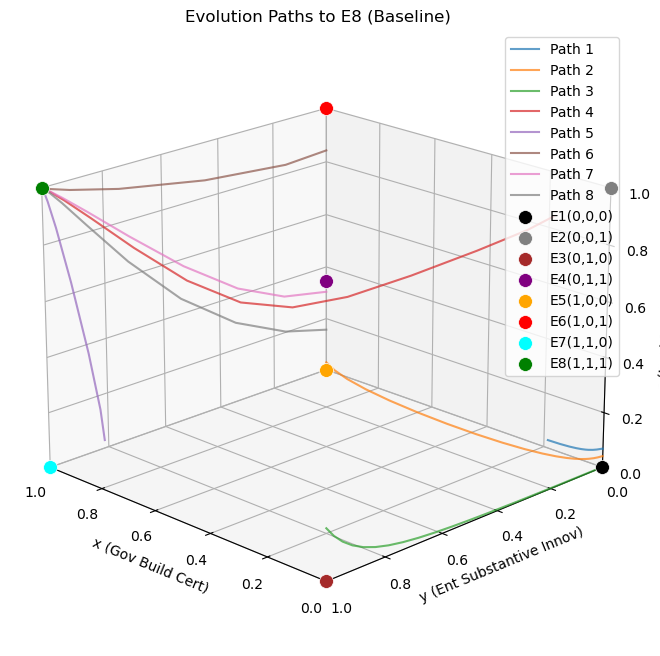

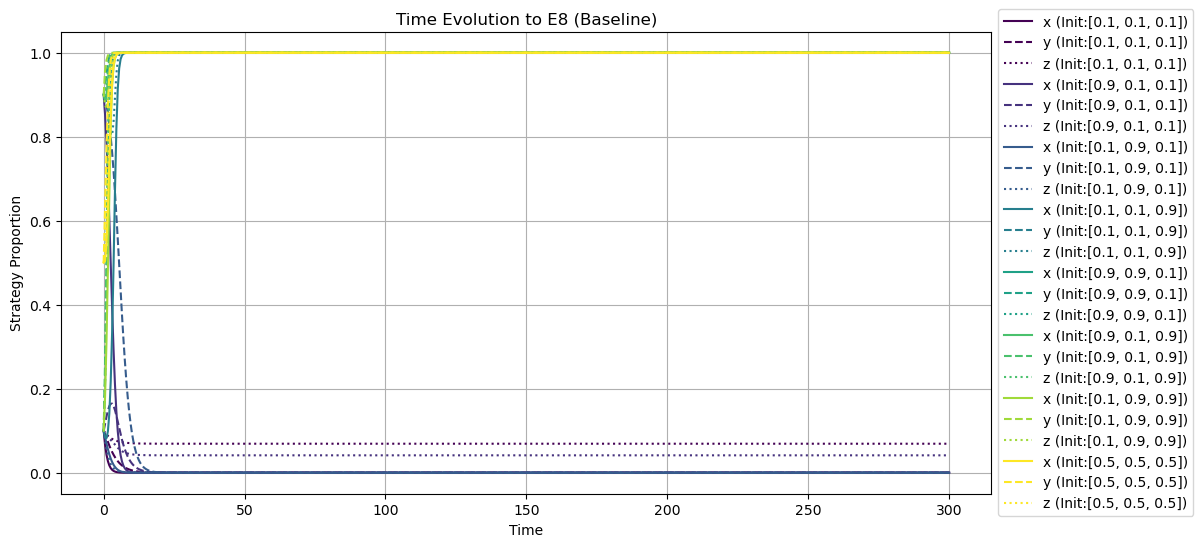

Baseline Scenario Final States: ['Not Converged', 'Not Converged', 'Not Converged', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)']

--- 需避免的不良均衡 (E1) ---


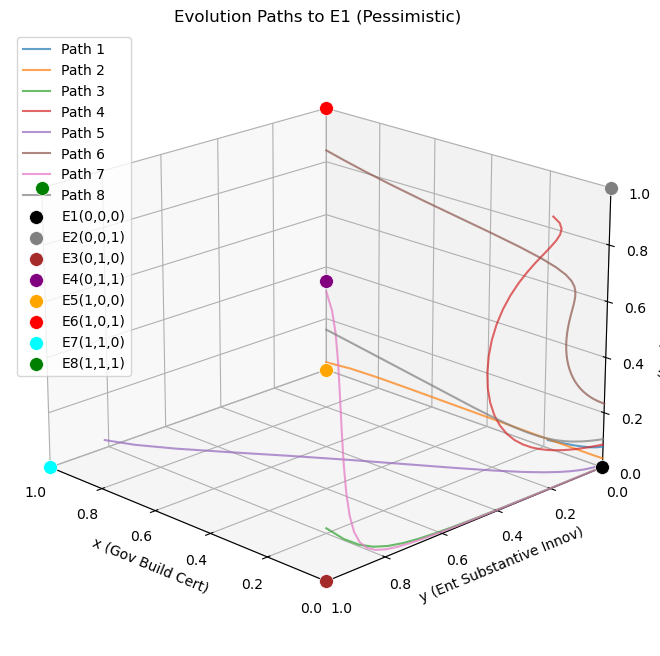

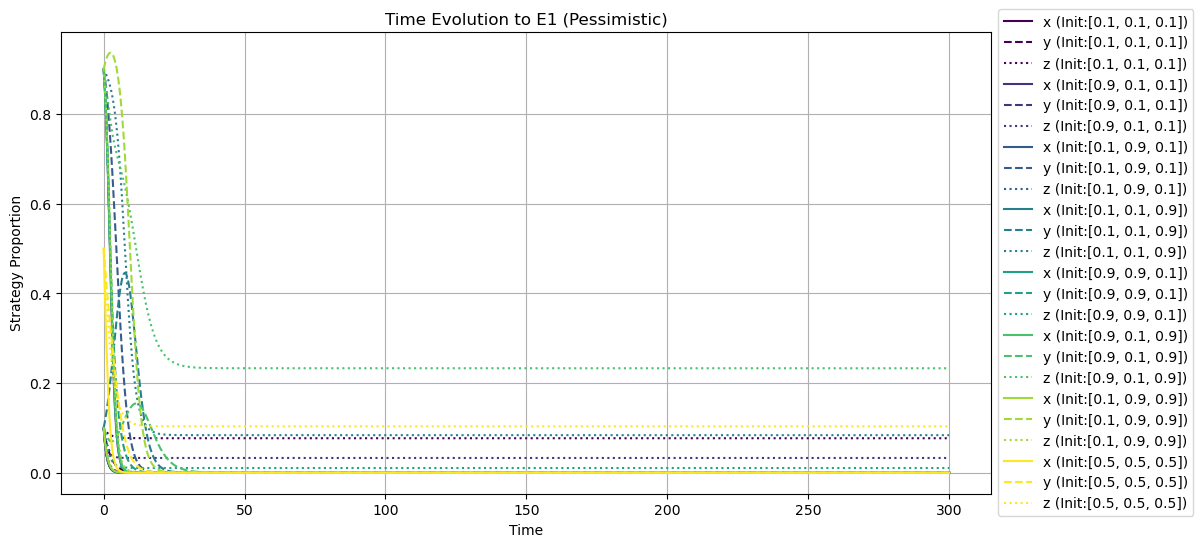

Pessimistic Scenario Final States: ['Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged']

--- 需避免的不良均衡 (E6 - 监管套利示例) ---


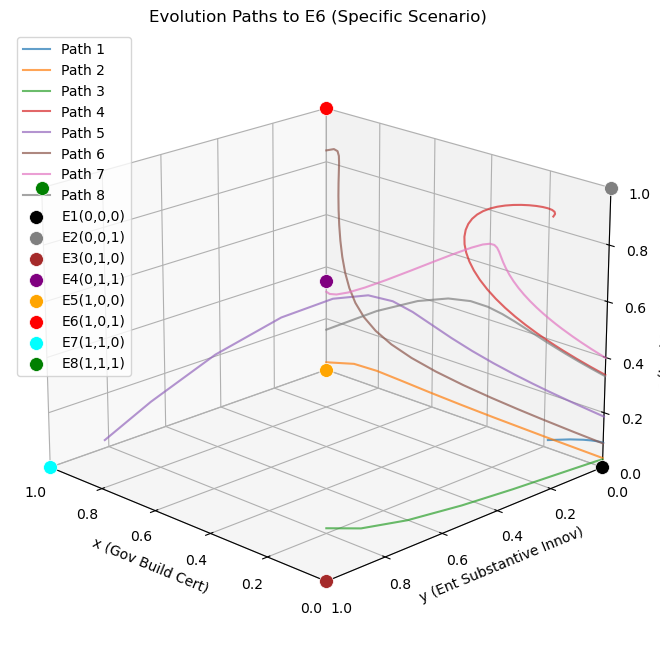

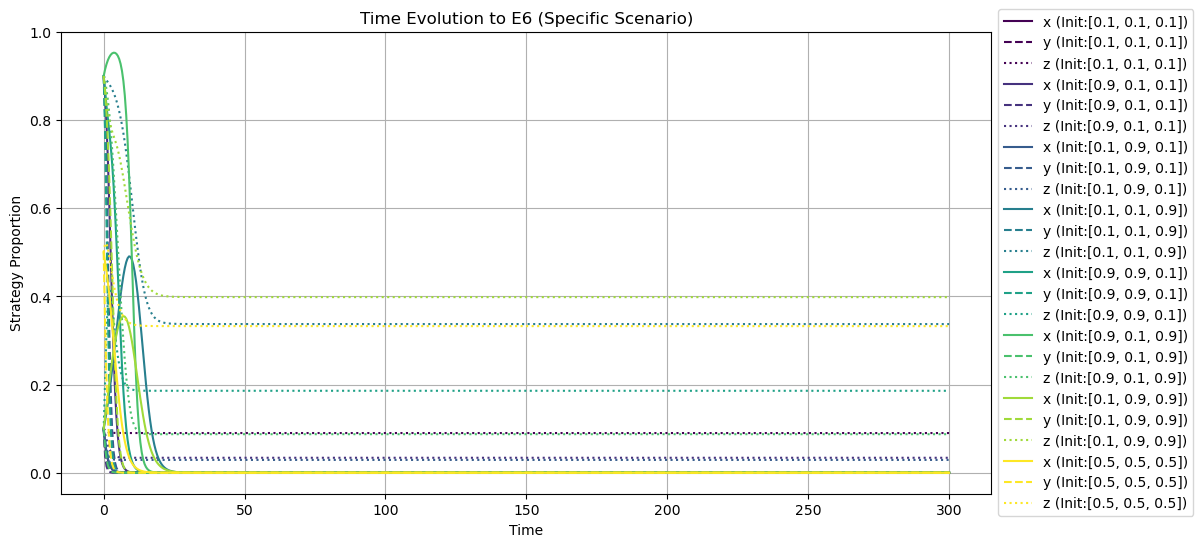

E6 Stable Scenario Final States: ['Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged', 'Not Converged']

--- 需避免的不良均衡 (E3 - 创新无投资示例) ---


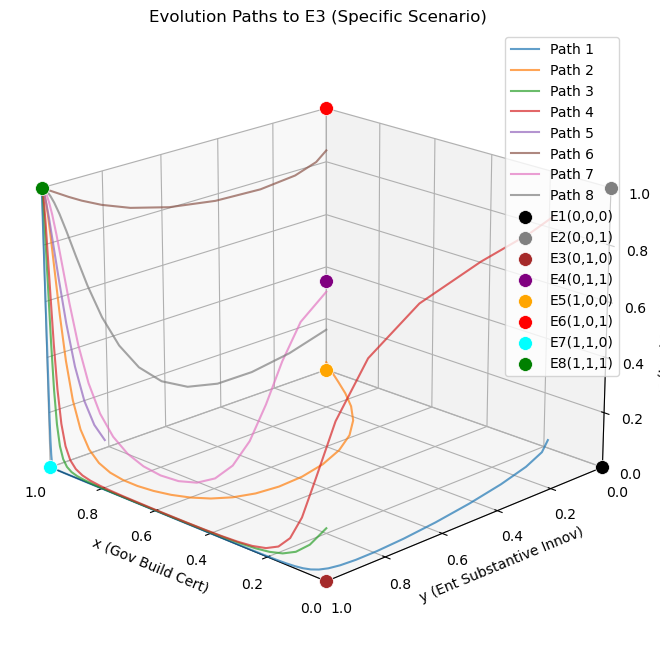

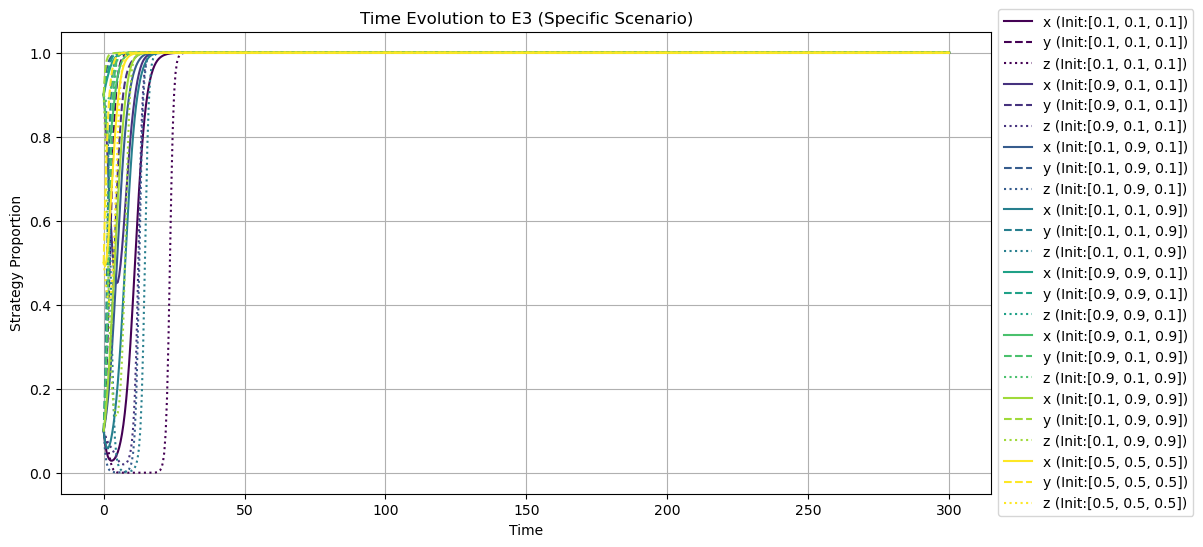

E3 Stable Scenario Final States: ['E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)', 'E8(1,1,1)']

--- 6.2 政策工具的有效性与边界分析 ---

--- 单一政策工具影响：企业认证净收益 (BE - CcertE) ---


Scanning BE - CcertE: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.77it/s]


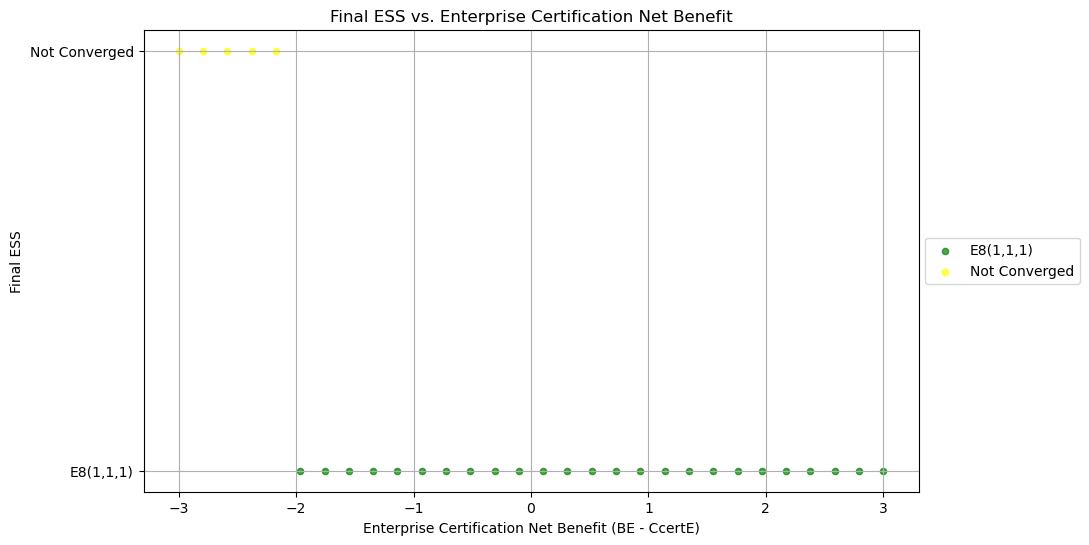


--- 代表性企业认证净收益下的时间演化 ---


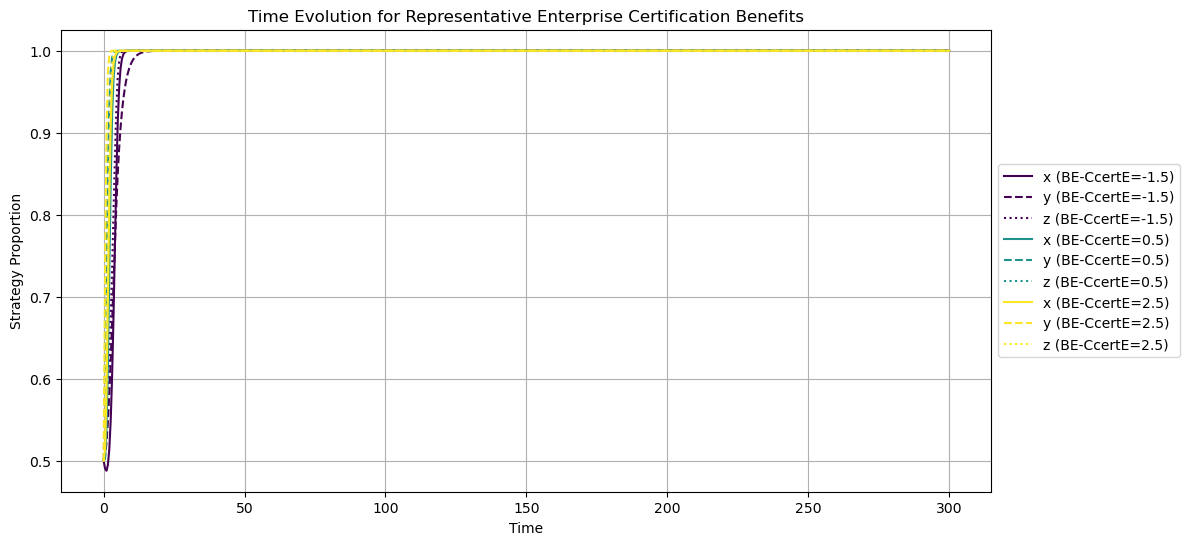


--- 单一政策工具影响：投资机构长期投资净收益 (PH + BI - CcertI - PO) ---


Scanning Inv Net Benefit: 100%|████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.34it/s]


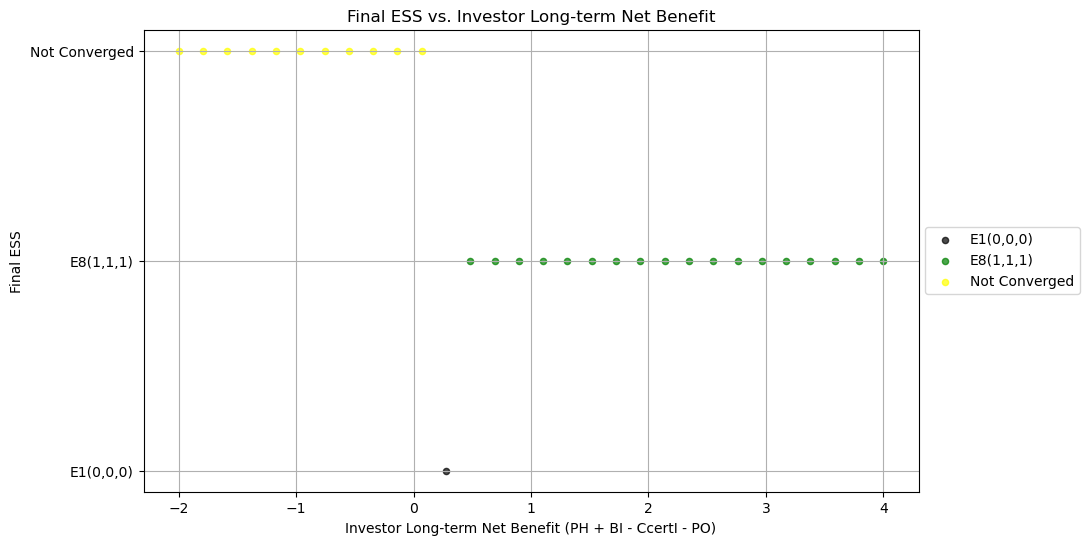


--- 代表性投资机构长期投资净收益下的时间演化 ---


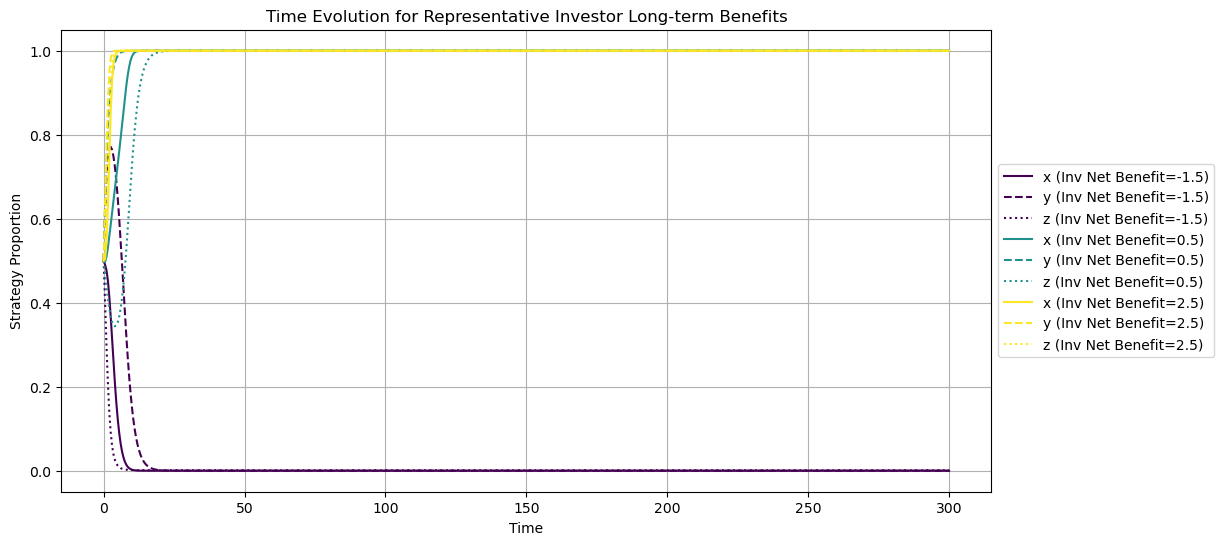


--- 政策工具组合影响：企业认证净收益 vs. 投资机构长期投资净收益 ---


Scanning 2D Parameter Space: 100%|███████████████████████████████████████████████| 400/400 [00:03<00:00, 133.05it/s]


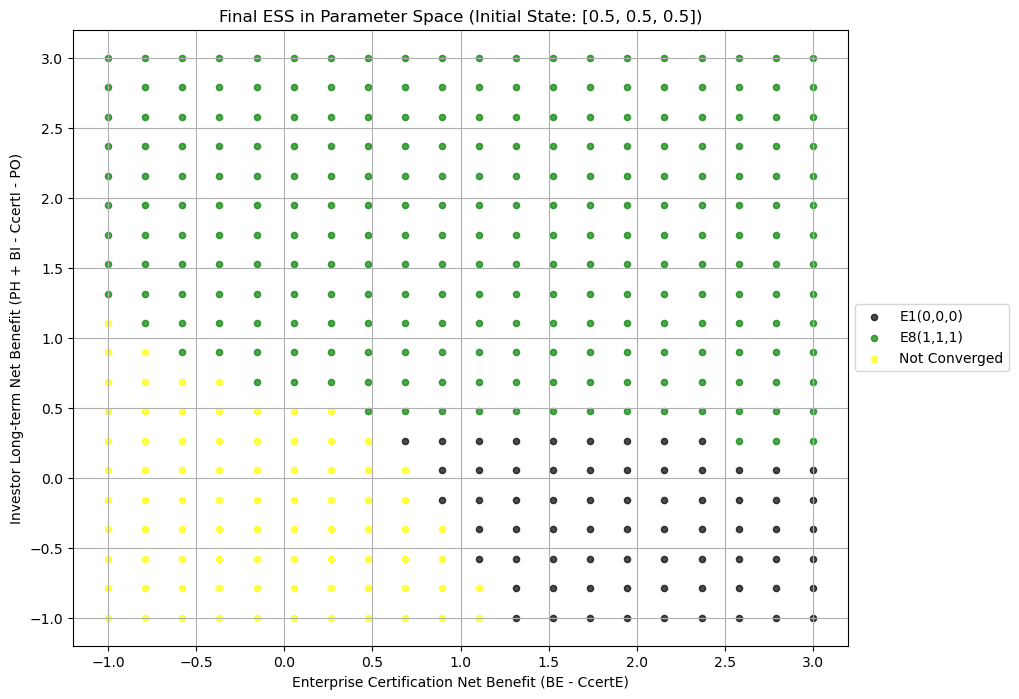


--- 6.3 政策实施的挑战：路径依赖与吸引域 ---

--- 双稳态情景下的吸引域 ---


Calculating Basin of Attraction: 100%|█████████████████████████████████████████| 2000/2000 [00:13<00:00, 143.28it/s]


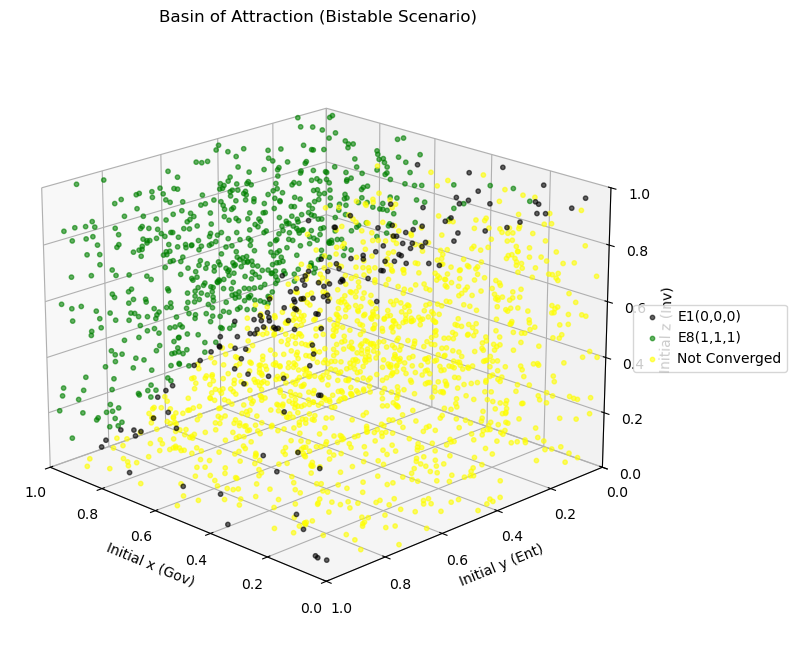


Basin of Attraction Distribution:
E1(0,0,0): 150 (7.50%)
E8(1,1,1): 584 (29.20%)
Not Converged: 1266 (63.30%)

--- 6.4 政策建议总结 ---
基于以上仿真结果，您可以讨论以下政策建议：
1. 实现理想均衡 (E8) 需要的关键政策参数阈值。
2. 避免不良均衡 (E1, E3, E6等) 需要注意的参数陷阱。
3. 政策工具组合的协同效应，例如同时激励企业和投资机构。
4. 在多重均衡下，政策实施需要考虑初始状态和路径依赖，可能需要初期更强的干预来引导系统。
5. 结合吸引域大小，评估不同政策干预的难度和潜在效果。
请根据您的具体仿真结果和理论分析，详细阐述这些政策建议。


In [4]:
# --- 4. 绘图函数 ---
def plot_3d_paths(solutions, title, pure_equilibria=None, elev=20, azim=135):
    """
    绘制三维演化路径图。
    solutions: 包含多个仿真结果的列表
    title: 图的标题
    pure_equilibria: 纯策略均衡点列表，用于在图中标记
    elev, azim: 3D视角参数
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, sol in enumerate(solutions):
        # 为不同的路径使用不同的颜色
        ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], alpha=0.7, label=f'Path {i+1}')
    # 标记纯策略均衡点
    if pure_equilibria:
        pure_equilibria_array = np.array(pure_equilibria)
        # 使用不同的颜色和标记区分不同的纯策略均衡点
        ess_colors_scatter = {
            (0,0,0): 'black', (0,0,1): 'gray',
            (0,1,0): 'brown', (0,1,1): 'purple',
            (1,0,0): 'orange', (1,0,1): 'red',
            (1,1,0): 'cyan', (1,1,1): 'green'
        }
        for eq in pure_equilibria:
             ax.scatter(eq[0], eq[1], eq[2], c=ess_colors_scatter.get(eq, 'blue'), marker='o', s=100, label=eq_names.get(eq, str(eq)), edgecolors='w', linewidth=0.5)
    ax.set_xlabel('x (Gov Build Cert)')
    ax.set_ylabel('y (Ent Substantive Innov)')
    ax.set_zlabel('z (Inv Long-term)')
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.view_init(elev=elev, azim=azim) # 调整视角
    ax.legend()
    plt.show()
def plot_time_evolution(solutions, initial_states_labels, title):
    """
    绘制策略比例随时间变化的曲线图。
    solutions: 包含多个仿真结果的列表
    initial_states_labels: 对应的初始状态或参数标签列表 (用于图例)
    title: 图的标题
    """
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(solutions))) # 使用颜色映射区分不同路径
    for i, sol in enumerate(solutions):
        plt.plot(t_span, sol[:, 0], label=f'x ({initial_states_labels[i]})', linestyle='-', color=colors[i])
        plt.plot(t_span, sol[:, 1], label=f'y ({initial_states_labels[i]})', linestyle='--', color=colors[i])
        plt.plot(t_span, sol[:, 2], label=f'z ({initial_states_labels[i]})', linestyle=':', color=colors[i])
    plt.xlabel('Time')
    plt.ylabel('Strategy Proportion')
    plt.title(title)
    # 调整图例，避免过于拥挤
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
def plot_parameter_sensitivity(sensitivity_results, param_name, title):
    """
    绘制最终ESS随参数变化的散点图。
    sensitivity_results: 包含 (param_val, final_ess) 元组的列表
    param_name: 参数名称 (用于x轴标签)
    title: 图的标题
    """
    plt.figure(figsize=(10, 6))
    results_df = pd.DataFrame(sensitivity_results, columns=['ParamValue', 'FinalESS'])
    # 为不同的 ESS 分配颜色和标记
    ess_colors_scatter = {
        (0,0,0): 'black', (0,0,1): 'gray',
        (0,1,0): 'brown', (0,1,1): 'purple',
        (1,0,0): 'orange', (1,0,1): 'red',
        (1,1,0): 'cyan', (1,1,1): 'green',
        'Mixed/Other': 'blue', 'Not Converged': 'yellow'
    }
    for ess_name, group in results_df.groupby('FinalESS'):
        # 使用 eq_names 映射纯策略均衡点名称
        label = eq_names.get(ess_name, ess_name)
        color = ess_colors_scatter.get(ess_name, 'blue') # 获取颜色，如果不在字典中则使用蓝色
        plt.scatter(group['ParamValue'], [label] * len(group), c=color, label=label, s=20, alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Final ESS')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
def plot_parameter_space(parameter_space_results, param_name_x, param_name_y, title):
    """
    绘制二维参数空间中不同区域收敛到的ESS图。
    parameter_space_results: 包含 (param_val_x, param_val_y, final_ess) 元组的列表
    param_name_x: x轴参数名称
    param_name_y: y轴参数名称
    title: 图的标题
    """
    plt.figure(figsize=(10, 8))
    results_df = pd.DataFrame(parameter_space_results, columns=['ParamValueX', 'ParamValueY', 'FinalESS'])
    # 为不同的 ESS 分配颜色和标记
    ess_colors_scatter = {
        (0,0,0): 'black', (0,0,1): 'gray',
        (0,1,0): 'brown', (0,1,1): 'purple',
        (1,0,0): 'orange', (1,0,1): 'red',
        (1,1,0): 'cyan', (1,1,1): 'green',
        'Mixed/Other': 'blue', 'Not Converged': 'yellow'
    }
    for ess_name, group in results_df.groupby('FinalESS'):
        label = eq_names.get(ess_name, ess_name)
        color = ess_colors_scatter.get(ess_name, 'blue')
        plt.scatter(group['ParamValueX'], group['ParamValueY'], c=color, label=label, s=20, alpha=0.7)
    plt.xlabel(param_name_x)
    plt.ylabel(param_name_y)
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
def plot_basin_of_attraction(basin_results, title):
    """
    绘制吸引域的三维散点图。
    basin_results: 包含 (x0, y0, z0, final_ess) 元组的列表
    title: 图的标题
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    basin_df = pd.DataFrame(basin_results, columns=['x0', 'y0', 'z0', 'FinalESS'])
    # 为不同的 ESS 分配颜色和标记
    ess_colors_scatter = {
        (0,0,0): 'black', (0,0,1): 'gray',
        (0,1,0): 'brown', (0,1,1): 'purple',
        (1,0,0): 'orange', (1,0,1): 'red',
        (1,1,0): 'cyan', (1,1,1): 'green',
        'Mixed/Other': 'blue', 'Not Converged': 'yellow'
    }
    for ess_name, group in basin_df.groupby('FinalESS'):
        label = eq_names.get(ess_name, ess_name)
        color = ess_colors_scatter.get(ess_name, 'blue')
        ax.scatter(group['x0'], group['y0'], group['z0'], c=color, label=label, s=10, alpha=0.6)
    ax.set_xlabel('Initial x (Gov)')
    ax.set_ylabel('Initial y (Ent)')
    ax.set_zlabel('Initial z (Inv)')
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.view_init(elev=20, azim=135) # 调整视角
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
# --- 5. 仿真分析流程引言 ---
print("--- 5. 仿真分析流程引言 ---")
print("本部分将根据政策导向的规划，进行数值仿真分析，旨在为政府制定促进创新生态发展的政策提供科学依据。")
print("仿真将重点分析不同政策工具（参数）对系统均衡和演化路径的影响，并探索政策实施的挑战。")
# --- 6. 政策导向的仿真分析流程 ---
# 时间跨度
t_span = np.linspace(0, 300, 601) # 增加仿真时间，提高收敛可能性
# 纯策略均衡点列表
pure_equilibria = list(itertools.product([0, 1], repeat=3))
# 映射到名称方便显示
eq_names = {
    (0,0,0): 'E1(0,0,0)', (0,0,1): 'E2(0,0,1)',
    (0,1,0): 'E3(0,1,0)', (0,1,1): 'E4(0,1,1)',
    (1,0,0): 'E5(1,0,0)', (1,0,1): 'E6(1,0,1)',
    (1,1,0): 'E7(1,1,0)', (1,1,1): 'E8(1,1,1)'
}
# --- 6.1 政策目标与潜在均衡分析 ---
print("\n--- 6.1 政策目标与潜在均衡分析 ---")
# 理想政策目标均衡 (E8)
print("\n--- 理想政策目标均衡 (E8) ---")
params_baseline = get_parameters('baseline')
# 选择代表性的初始条件，覆盖策略空间的各个角落和中心
initial_states_representative = [
    [0.1, 0.1, 0.1], [0.9, 0.1, 0.1], [0.1, 0.9, 0.1], [0.1, 0.1, 0.9],
    [0.9, 0.9, 0.1], [0.9, 0.1, 0.9], [0.1, 0.9, 0.9], [0.5, 0.5, 0.5]
]
solutions_baseline = [solve_replicator_dynamics(init, params_baseline, t_span) for init in initial_states_representative]
plot_3d_paths(solutions_baseline, 'Evolution Paths to E8 (Baseline)', pure_equilibria)
plot_time_evolution(solutions_baseline, [f'Init:{init}' for init in initial_states_representative], 'Time Evolution to E8 (Baseline)')
final_states_baseline = [get_final_state(sol) for sol in solutions_baseline]
print("Baseline Scenario Final States:", [eq_names.get(fs, fs) for fs in final_states_baseline])
# 需避免的不良均衡 (E1)
print("\n--- 需避免的不良均衡 (E1) ---")
params_pessimistic = get_parameters('pessimistic')
solutions_pessimistic = [solve_replicator_dynamics(init, params_pessimistic, t_span) for init in initial_states_representative]
plot_3d_paths(solutions_pessimistic, 'Evolution Paths to E1 (Pessimistic)', pure_equilibria)
plot_time_evolution(solutions_pessimistic, [f'Init:{init}' for init in initial_states_representative], 'Time Evolution to E1 (Pessimistic)')
final_states_pessimistic = [get_final_state(sol) for sol in solutions_pessimistic]
print("Pessimistic Scenario Final States:", [eq_names.get(fs, fs) for fs in final_states_pessimistic])
# 需避免的不良均衡 (特殊均衡点示例: E6)
print("\n--- 需避免的不良均衡 (E6 - 监管套利示例) ---")
params_E6 = get_parameters('E6_stable')
solutions_E6 = [solve_replicator_dynamics(init, params_E6, t_span) for init in initial_states_representative]
plot_3d_paths(solutions_E6, 'Evolution Paths to E6 (Specific Scenario)', pure_equilibria)
plot_time_evolution(solutions_E6, [f'Init:{init}' for init in initial_states_representative], 'Time Evolution to E6 (Specific Scenario)')
final_states_E6 = [get_final_state(sol) for sol in solutions_E6] # 修正：这里应该是 solutions_E6
print("E6 Stable Scenario Final States:", [eq_names.get(fs, fs) for fs in final_states_E6])
# 需避免的不良均衡 (特殊均衡点示例: E3)
print("\n--- 需避免的不良均衡 (E3 - 创新无投资示例) ---")
params_E3 = get_parameters('E3_stable')
solutions_E3 = [solve_replicator_dynamics(init, params_E3, t_span) for init in initial_states_representative]
plot_3d_paths(solutions_E3, 'Evolution Paths to E3 (Specific Scenario)', pure_equilibria)
plot_time_evolution(solutions_E3, [f'Init:{init}' for init in initial_states_representative], 'Time Evolution to E3 (Specific Scenario)')
final_states_E3 = [get_final_state(sol) for sol in solutions_E3] # 修正：这里应该是 solutions_E3
print("E3 Stable Scenario Final States:", [eq_names.get(fs, fs) for fs in final_states_E3])
# --- 6.2 政策工具的有效性与边界分析 ---
print("\n--- 6.2 政策工具的有效性与边界分析 ---")
# 单一政策工具影响：企业认证净收益 (BE - CcertE)
print("\n--- 单一政策工具影响：企业认证净收益 (BE - CcertE) ---")
# 扫描参数范围
param_range_BE_CcertE = np.linspace(-3.0, 3.0, 30) # 增加扫描点数
# 固定其他参数 (例如使用基准情景的参数作为基础)
base_params_sensitivity = get_parameters('baseline')
# 选择一个或几个初始条件进行敏感性分析
initial_state_sensitivity = [0.5, 0.5, 0.5] # 从中心点开始
sensitivity_results_BE = []
# 使用 tqdm 显示进度条 (如果安装了 tqdm 库)
try:
    from tqdm import tqdm
    param_iterator_BE = tqdm(param_range_BE_CcertE, desc="Scanning BE - CcertE")
except ImportError:
    param_iterator_BE = param_range_BE_CcertE
    print("Install tqdm for progress bar: pip install tqdm")
for param_val in param_iterator_BE:
    current_params = base_params_sensitivity.copy()
    current_params['B_E'] = param_val + current_params['C_certE']
    sol = solve_replicator_dynamics(initial_state_sensitivity, current_params, t_span)
    final_ess = get_final_state(sol)
    sensitivity_results_BE.append((param_val, final_ess))
    # print(f"BE - CcertE = {param_val:.2f} -> Final ESS: {eq_names.get(final_ess, final_ess)}") # 打印信息可能过多，可选
# 绘制 ESS vs. Parameter 图
plot_parameter_sensitivity(sensitivity_results_BE, 'Enterprise Certification Net Benefit (BE - CcertE)', 'Final ESS vs. Enterprise Certification Net Benefit')
# 绘制代表性参数值下的时间演化图
print("\n--- 代表性企业认证净收益下的时间演化 ---")
# 根据敏感性分析结果，选择几个能代表不同均衡状态的参数值
representative_params_BE = [-1.5, 0.5, 2.5] # 示例值，请根据您的敏感性分析结果调整
solutions_sensitivity_BE = []
initial_states_sensitivity_BE_labels = []
for param_val in representative_params_BE:
     current_params = base_params_sensitivity.copy()
     current_params['B_E'] = param_val + current_params['C_certE']
     solutions_sensitivity_BE.append(solve_replicator_dynamics(initial_state_sensitivity, current_params, t_span))
     initial_states_sensitivity_BE_labels.append(f'BE-CcertE={param_val:.1f}')
plot_time_evolution(solutions_sensitivity_BE, initial_states_sensitivity_BE_labels, 'Time Evolution for Representative Enterprise Certification Benefits')
# 单一政策工具影响：投资机构长期投资净收益 (PH + BI - CcertI - PO)
print("\n--- 单一政策工具影响：投资机构长期投资净收益 (PH + BI - CcertI - PO) ---")
# 扫描参数范围
param_range_Inv_NetBenefit = np.linspace(-2.0, 4.0, 30) # 增加扫描点数
# 固定其他参数 (例如使用基准情景的参数作为基础)
base_params_sensitivity_inv = get_parameters('baseline')
# 选择一个或几个初始条件进行敏感性分析
initial_state_sensitivity_inv = [0.5, 0.5, 0.5] # 从中心点开始
sensitivity_results_Inv = []
# 使用 tqdm 显示进度条
try:
    from tqdm import tqdm
    param_iterator_Inv = tqdm(param_range_Inv_NetBenefit, desc="Scanning Inv Net Benefit")
except ImportError:
    param_iterator_Inv = param_range_Inv_NetBenefit
for param_val in param_iterator_Inv:
    current_params = base_params_sensitivity_inv.copy()
    current_params['P_H'] = param_val - current_params['B_I'] + current_params['C_certI'] + current_params['P_O']
    sol = solve_replicator_dynamics(initial_state_sensitivity_inv, current_params, t_span)
    final_ess = get_final_state(sol)
    sensitivity_results_Inv.append((param_val, final_ess))
    # print(f"Inv Net Benefit = {param_val:.2f} -> Final ESS: {eq_names.get(final_ess, final_ess)}") # 打印信息可能过多，可选
# 绘制 ESS vs. Parameter 图
plot_parameter_sensitivity(sensitivity_results_Inv, 'Investor Long-term Net Benefit (PH + BI - CcertI - PO)', 'Final ESS vs. Investor Long-term Net Benefit')
# 绘制代表性参数值下的时间演化图
print("\n--- 代表性投资机构长期投资净收益下的时间演化 ---")
# 根据敏感性分析结果，选择几个能代表不同均衡状态的参数值
representative_params_Inv = [-1.5, 0.5, 2.5] # 示例值，请根据您的敏感性分析结果调整
solutions_sensitivity_Inv = []
initial_states_sensitivity_Inv_labels = []
for param_val in representative_params_Inv:
     current_params = base_params_sensitivity_inv.copy()
     current_params['P_H'] = param_val - current_params['B_I'] + current_params['C_certI'] + current_params['P_O']
     solutions_sensitivity_Inv.append(solve_replicator_dynamics(initial_state_sensitivity_inv, current_params, t_span))
     initial_states_sensitivity_Inv_labels.append(f'Inv Net Benefit={param_val:.1f}')
plot_time_evolution(solutions_sensitivity_Inv, initial_states_sensitivity_Inv_labels, 'Time Evolution for Representative Investor Long-term Benefits')
# 政策工具组合影响：企业认证净收益 vs. 投资机构长期投资净收益
print("\n--- 政策工具组合影响：企业认证净收益 vs. 投资机构长期投资净收益 ---")
# 扫描两个参数的二维空间
param_range_BE_CcertE_2d = np.linspace(-1.0, 3.0, 20) # 增加扫描点数
param_range_Inv_NetBenefit_2d = np.linspace(-1.0, 3.0, 20) # 增加扫描点数
# 固定其他参数 (例如使用基准情景的参数作为基础)
base_params_2d = get_parameters('baseline')
# 选择一个初始条件
initial_state_2d = [0.5, 0.5, 0.5]
parameter_space_results = []
# 使用 tqdm 显示进度条
try:
    from tqdm import tqdm
    param_iterator_2d = tqdm(itertools.product(param_range_BE_CcertE_2d, param_range_Inv_NetBenefit_2d),
                          total=len(param_range_BE_CcertE_2d) * len(param_range_Inv_NetBenefit_2d),
                          desc="Scanning 2D Parameter Space")
except ImportError:
    param_iterator_2d = itertools.product(param_range_BE_CcertE_2d, param_range_Inv_NetBenefit_2d)
    print("Install tqdm for progress bar: pip install tqdm")
for be_ccerte_val, inv_net_benefit_val in param_iterator_2d:
    current_params = base_params_2d.copy()
    current_params['B_E'] = be_ccerte_val + current_params['C_certE']
    current_params['P_H'] = inv_net_benefit_val - current_params['B_I'] + current_params['C_certI'] + current_params['P_O']
    sol = solve_replicator_dynamics(initial_state_2d, current_params, t_span)
    final_ess = get_final_state(sol)
    parameter_space_results.append((be_ccerte_val, inv_net_benefit_val, final_ess))
# 绘制 ESS in Parameter Space 图
plot_parameter_space(parameter_space_results, 'Enterprise Certification Net Benefit (BE - CcertE)', 'Investor Long-term Net Benefit (PH + BI - CcertI - PO)', 'Final ESS in Parameter Space (Initial State: [0.5, 0.5, 0.5])')
# --- 6.3 政策实施的挑战：路径依赖与吸引域 ---
print("\n--- 6.3 政策实施的挑战：路径依赖与吸引域 ---")
# 双稳态情景下的吸引域
print("\n--- 双稳态情景下的吸引域 ---")
params_bistable = get_parameters('bistable')
# 生成大量随机初始条件
num_initial_conditions = 2000 # 增加初始点数量，更精细地描绘吸引域
initial_states_basin = np.random.rand(num_initial_conditions, 3)
basin_results = []
# 使用 tqdm 显示进度条
try:
    from tqdm import tqdm
    initial_state_iterator_basin = tqdm(initial_states_basin, desc="Calculating Basin of Attraction")
except ImportError:
    initial_state_iterator_basin = initial_states_basin
for init_state in initial_state_iterator_basin:
    sol = solve_replicator_dynamics(init_state, params_bistable, t_span)
    final_ess = get_final_state(sol)
    basin_results.append((init_state[0], init_state[1], init_state[2], final_ess))
# 绘制吸引域图
plot_basin_of_attraction(basin_results, 'Basin of Attraction (Bistable Scenario)')
# 统计各均衡点的吸引域大小 (近似比例)
ess_counts = Counter([eq_names.get(res[3], res[3]) for res in basin_results])
total_runs = len(basin_results)
print("\nBasin of Attraction Distribution:")
for ess, count in ess_counts.items():
    print(f"{ess}: {count} ({count/total_runs:.2%})")
# --- 6.4 政策建议总结 (这部分是基于以上仿真结果的文字讨论，代码无法直接生成) ---
print("\n--- 6.4 政策建议总结 ---")
print("基于以上仿真结果，您可以讨论以下政策建议：")
print("1. 实现理想均衡 (E8) 需要的关键政策参数阈值。")
print("2. 避免不良均衡 (E1, E3, E6等) 需要注意的参数陷阱。")
print("3. 政策工具组合的协同效应，例如同时激励企业和投资机构。")
print("4. 在多重均衡下，政策实施需要考虑初始状态和路径依赖，可能需要初期更强的干预来引导系统。")
print("5. 结合吸引域大小，评估不同政策干预的难度和潜在效果。")
print("请根据您的具体仿真结果和理论分析，详细阐述这些政策建议。")